# Subspace-Search Variational Quantum Eigensolver
As explained in section 5-1, the variational quantum eigensolver (VQE) is an algorithm for searching the ground state of a quantum system. The ground state is an important state that determines the properties of various substances, but there are also phenomena such as photoresponse that are difficult to describe without the excited states.

Therefore, algorithms for generating a wave function of an excited state on a quantum computer have been actively studied. Among them, here a new method proposed in 2018, Subspace-Search VQE (SSVQE) [1] is introduced.

This notebook is translated from https://dojo.qulacs.org/ja/latest/notebooks/6.3_subspace_search_VQE.html

## Algorithnm
The procedures for SSVQE is as following:

1. Prepare $k$ initial states $\{\left|\varphi_i\right>\}_{i=0}^{k-1}$ orthogonal to each other.
2. For each of them, operate an appropriate quantum circuit $U(\theta)$ to generate a trial state. (Note: $\left|\psi_i(\theta)\right>=U(\theta)\left|\varphi_i\right>$)
3. Adjust $\theta$ to minimize cost function $L(\theta)=\sum_i w_i \left<\psi_i(\theta)\left|H\right|\psi_i(\theta)\right>$. Here when $w_i$ is positive and $i>j$, make sure $w_i<w_j$. 

When $U(\theta)$ has sufficient expressiveness, $\left|\psi_i(\theta)\right>$ becomes the $i$th excited state at converged $\theta$. This is because when the $i$th excited state of the Hamiltonian is $\left|E_i\right>$, the global minimum of the cost function is $\left|\psi_i\right>=\left|E_i\right>$. (Refer to the original paper [1] for details)

The following shows an example of simulating SSVQE using Qulacs.

## Implementation of SSVQE
Implement SSVQE to search ground state and first excited state of hydrogen molecule. When hydrogen molecule is treated with sto-3g minimal basis set, 4 qubit Hamiltonian can be obtained. Therefore, two initial states, $\left|0000\right>$ and $\left|0001\right>$, which are flipped by one qubit, are used as orthogonal initial states required for SSVQE.

* Note for those who are familiar with quantum chemistry: The first excited state here is the first excited state of the Hamiltonian of a hydrogen molecule without considering the number of electrons, and in chemistry terms, the ground state of a hydrogen molecular ion.

### Create Hamiltonian
Follow the same procedure as explained before to calculate Hamiltonian using PySCF + OpenFermion. However, the excited state is considered in SSVQE, so `scipy.sparse.linalg.eigsh` is used to obtain the exact solution of excited state.

In [ ]:
## Please execute if various libraries are not installed
## When use Google Colaboratory, please ignore 'You must restart the runtime in order to use newly installed versions'.
## Crash when restarting runtime.
!pip install qulacs pyscf openfermion openfermionpyscf

In [1]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.transforms import get_sparse_operator
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
hamiltonian_matrix = get_sparse_operator(jw_hamiltonian)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(hamiltonian_matrix, k=2, which="SA")
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

### Construct ansatz
Create quantum circuit on Qulacs. Here, the quantum circuit is modeled after the experiments with superconducting qubits (A. Kandala et. al. , “Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets“, Nature **549**, 242–246).

In [3]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [4]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    circuit.add_gate(RY(0, theta_list[-2]))
    circuit.add_gate(RZ(0, theta_list[-1]))
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))

    return circuit

### Define cost function of SSVQE

In [5]:
def get_exp(state, theta_list):
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #Create quantum circuit
    circuit.update_quantum_state(state) #Operate on quantum state
    return qulacs_hamiltonian.get_expectation_value(state)

def cost(theta_list):
    state0 = QuantumState(n_qubit) #Prepare |00000>
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1) #Prepare |00001>
    return get_exp(state0, theta_list)+0.5*get_exp(state1, theta_list)

init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
cost(init_theta_list)

0.21631044919594045

### Run SSVQE
Now everthing is prepared, run SSVQE. For optimization, the BFGS method implemented in scipy is applied, and initial parameters are randomly selected. This process should end in tens of seconds.

In [6]:
exp_history0 = []
exp_history1 = []
def callback(theta_list):
    state0 = QuantumState(n_qubit) #Prepare |0000>
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1) #Prepare |0001>
    exp_history0.append(get_exp(state0, theta_list))
    exp_history1.append(get_exp(state1, theta_list))
init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=callback)

The results can be plotted to see that they converge to the correct solution.

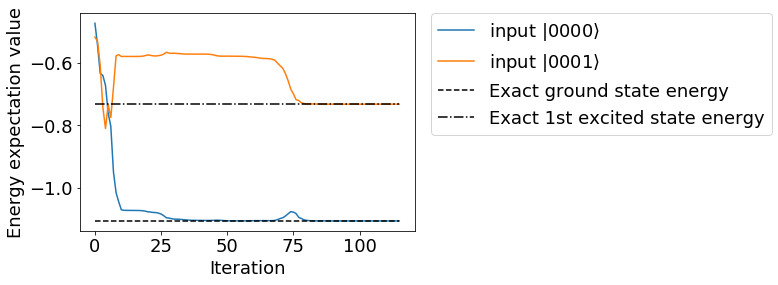

In [7]:
plt.rcParams["font.size"] = 18
plt.plot(exp_history0, label=r"input $|0000\rangle$")
plt.plot(exp_history1, label=r"input $|0001\rangle$")
plt.plot(range(len(exp_history0)), [molecule.fci_energy]*len(exp_history0), linestyle="dashed", color="black", label="Exact ground state energy")
plt.plot(range(len(exp_history1)), [eigval[1]]*len(exp_history1), linestyle="-.", color="black", label="Exact 1st excited state energy")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

## Reference
[1] K. M Nakanishi, K. Mitarai, and K. Fujii, “Subspace-search variational quantum eigensolver for excited states”, Phys. Rev. Research 1, 033062 (2019), https://arxiv.org/abs/1810.09434
